## Настройка библиотек

### pandas

Для его настройки достаточно просто сделать импорт.

Также добавим numpy и matplotlib - пригодится для быстрых преобразований данных и визуализаций.

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### pyspark

PySpark прежде всего требует установки самого Spark и платформы Java. Установим свободный JDK (Java development kit) версии 8. А Apache Spark скачаем версии 3.5.0 с Hadoop.

In [274]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

После этого в окружение среды нужно указать пути JAVA_HOME и SPARK_HOME на скачанные программы. Поскольку мы напрямую загрузили Spark, то он находится в директории content. Чтобы их добавить воспользуемся модулем os, который предоставляет интерфейс для взаимодействия с файловой системой.

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.5.0-bin-hadoop3"

Чтобы использовать PySpark как обычную Python-библиотеку, установим findspark, который сделает за нас остальную работу по инициализации.

In [5]:
!pip install findspark

Осталось инициализировать PySpark. Для этого вызывается метод findspark.init(), а дальше создаём точку входа кластера.

In [6]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Загрузка данных

Очень часто при анализе данных мы работаем с датасетами Kaggle — онлайн-площадки для соревнований по машинному обучению как в рамках конкурсов, так и для личных исследований. Обычно датасеты с Kaggle скачиваются напрямую на компьютер. Потом их загружают либо в Google Colab, либо в Google Drive. Причём если они загружаются с Drive, то придётся также их подгружать в Colab и вводить код доступа. Оба метода достаточно долгие, особенно если файлы большого размера. Поэтому загрузим файлы напрямую с Kaggle в Colab через Kaggle API.

Для этого, прежде всего необходимо создать аккаунт Kaggle (если у вас его еще нет). А затем в настройках аккаунта нужно создать API Token. Рисунок ниже показывает соответствующий раздел. После этого скачается файл kaggle.json, который содержит ваш личный код доступа.
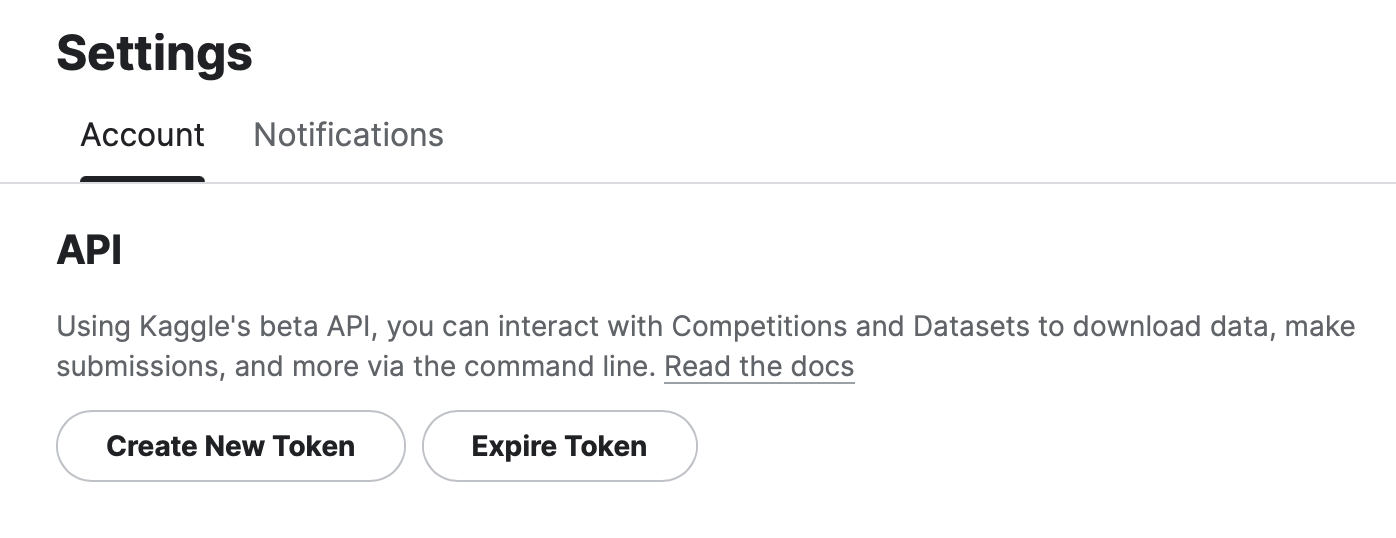

In [7]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"petrsed","key":"36bbdc3e5353a0b2694fc124441bcfc6"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

В этой и следующей практиках будем работать с [датасетом](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset), предназначенным для обучения алгоритма рекомендаций книг.

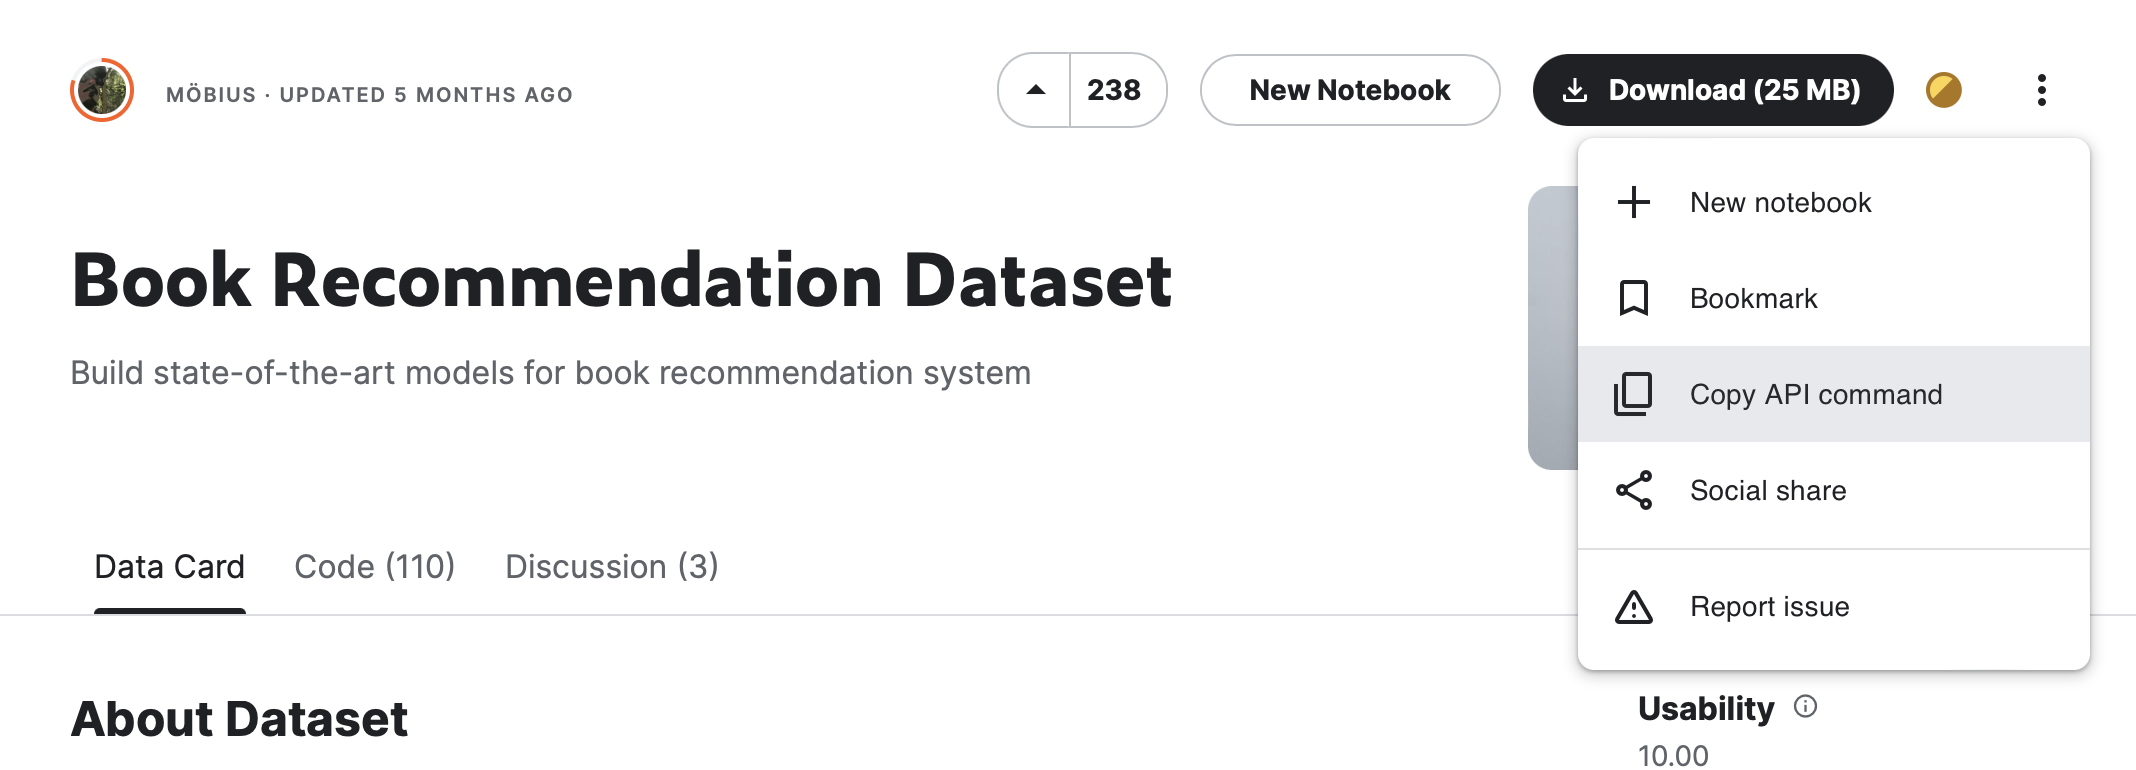

In [8]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

 21% 5.00M/23.8M [00:00<00:00, 47.4MB/s]
100% 23.8M/23.8M [00:00<00:00, 129MB/s] 


In [9]:
!unzip -q book-recommendation-dataset.zip

## Упражнения с данными в pandas

### Подготовка

Загрузим данные и посмотрим на них: выведите по 3 первые строки каждого датафрейма с помощью метода  [head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html).

In [275]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

display(books.head(3))
display(ratings.head(3))
display(users.head(3))

<ipython-input-275-3b325d4d72fd>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


Посмотрим на размеры датафреймов.

In [276]:
books.shape, ratings.shape, users.shape

((271360, 8), (1149780, 3), (278858, 3))

Воспользуйтесь [функцией](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge) или [методом](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) merge, чтобы объединить три датафрейма в один.

In [277]:


data = books.merge(ratings).merge(users)
display(data.shape)
display(data.head(3))

(1031136, 12)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN


В столбце Location указано достаточно много данных: город, регион, страна. Давайте разделим этот столбец на три с помощью метода [str.split()](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html) с параметром expand=True. Если в процессе у вас образовались лишние столбцы, удалите их методом [drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) с параметром inplace=True, чтобы не создавать новую таблицу. Это случилось потому, что со столбцом с локацией есть некоторые проблемы, но мы на них сейчас не будем обращать внимание.

In [278]:
location = data["Location"].str.split(',', expand=True, n=3)
location.rename(columns={0: 'First-Location', 1: 'Second-Location', 2: 'Third-Location'}, inplace=True)
data.drop(columns=['Location'], inplace=True)
data = data.merge(location, left_index=True, right_index=True)
data.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,First-Location,Second-Location,Third-Location,3
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,18.0,stockton,california,usa,None
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,NaN,timmins,ontario,canada,None
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,NaN,timmins,ontario,canada,None


Узнаем немного больше о книгах и пользователях.
1. Построим [гистограмму](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) распределения возрастов пользователей. Видно, что там есть отсутствующие значения. Будем их пока игнорировать.

In [279]:
data.Age.describe()

count    753301.000000
mean         37.397648
std          14.098254
min           0.000000
25%          28.000000
50%          35.000000
75%          45.000000
max         244.000000
Name: Age, dtype: float64

Было бы неплохо не смотреть на то, что читают младенцы и мумии: посмотрим на возраст больше 0 и меньше 100. Для того, чтобы отсеять лишние строки, можно воспользоваться методом [query()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html).

В конце строки, отвечающей за вывод визуализации для вывода изображения без лишних указателей, можно поставить `;` или в следующей строке написать plt.show().

(array([  4309.,  37936., 209496., 232913., 146897.,  87350.,  27179.,
          2821.,    584.,    345.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

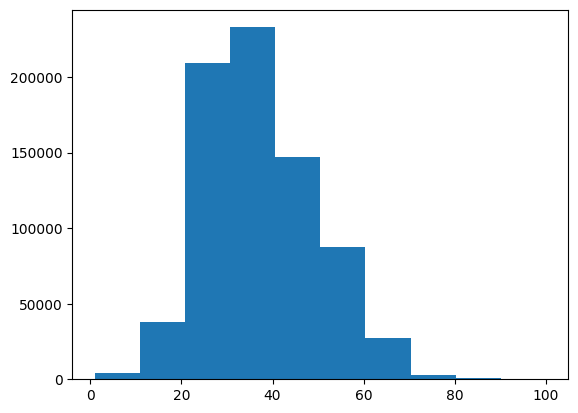

In [280]:
ages = data.query('0 < Age < 101')['Age']
plt.hist(ages)

Какой можно сделать вывод о возрасте пользователей?

Для пользователей с возрастом больше 100 лет поставим значение возраста np.nan. Можно сделать это с помощью метода [apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html), например.

(array([  4643.,  31676., 188782., 244593., 152967.,  93155.,  30315.,
          3147.,    723.,    390.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

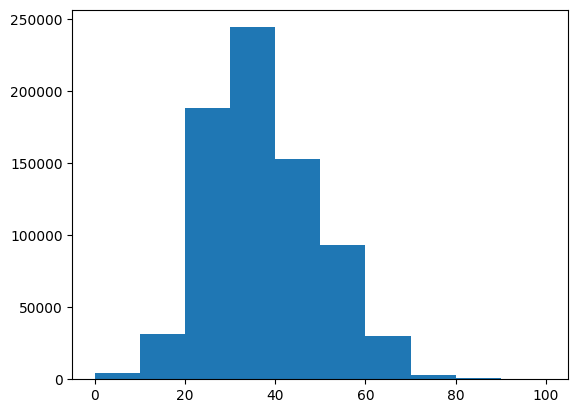

In [281]:
ages = data['Age'].apply(lambda x: np.nan if x > 100 else x)
plt.hist(ages)

2. Выясним, книги каких эпох представлены в датасете. Для этого построим еще диаграмму, теперь - с распределением кол-ва книг по годам.

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

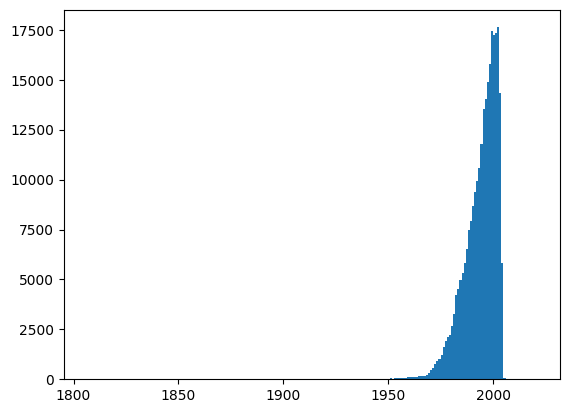

In [282]:
def convert_value(x):
  if isinstance(x, str):
    if x.isdigit():
      x = int(x)
    else:
      return np.nan
  if x < 1800 or x > 2023:
    return np.nan
  return x

years = books['Year-Of-Publication'].apply(convert_value)
bins = int(years.max() - years.min())
plt.hist(years, bins)

Вероятно, у вас возникла ошибка о невозможности сравнения строк и целых чисел. Посмотрите, нет ли чего несанкционированного в столбце с датой, например, выведя уникальные значения с помощью метода [unqiue()](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html).

In [283]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Часть чисел имеет вид строки - преобразовать не проблема. Но есть и две настоящих строки, на вид - названия издательств. Давайте посмотрим на строки с такими значениями.

In [284]:
years = data['Year-Of-Publication'].apply(lambda x: not str(x).isdigit())
data[years]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,First-Location,Second-Location,Third-Location,3
287500,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN,137190,0,31.0,rennes,bretagne,france,None
352361,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,227771,7,19.0,savion,n/a,israel,None
467962,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN,130571,0,NaN,summerville,south carolina,usa,None
469216,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,169663,0,NaN,towson,maryland,usa,None


В 4 строках некорректно открепили автора от названия. Для упрощения работы исключим эти строки из датасета.
>В качестве дополнительного упражнения верните порядок в эти строки с помощью pandas.

In [285]:
years = data['Year-Of-Publication'].apply(lambda x: str(x).isdigit())
data = data[years]

Теперь продолжим с построением графика. Но сначала преобразуем весь столбец в целые числа с помощью метода [astype()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html).

In [286]:
years = books['Year-Of-Publication'].apply(lambda x: str(x).isdigit())
books = books[years]

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.4000e+01, 2.3000e+01,
        3.6000e+01, 2.3000e+01, 3.5000e+01, 9.1000e+01, 6.7000e+01,
        3.6700e+02, 7.7600e+02, 1.7120e+03, 7.9710e+03, 2.9319e+04,
        5.5753e+04, 9.8061e+04, 7.2464e+04, 6.0000e+00, 4.0000e+00]),
 array([1806.        , 1813.16666667, 1820.33333333, 1827.5       ,
        1834.66666667, 1841.83333333, 1849.        , 1856.16666667,
        1863.33333333, 1870.5       , 1877.66666667, 1884.83333333,
        1892.        , 1899.16666667, 1906.33333333, 1913.5       ,
        1920.66666667, 1927.83333333, 1935.        , 1942.16666667,
        1949.33333333, 1956.5       , 1963.66666667, 1970.83333333,
        1978.        , 1985.16666667, 1992.33333333, 1999.5       ,
        2006.66666667, 2013.83333333, 2021.        ]),
 <BarContainer object of 30 artists>)

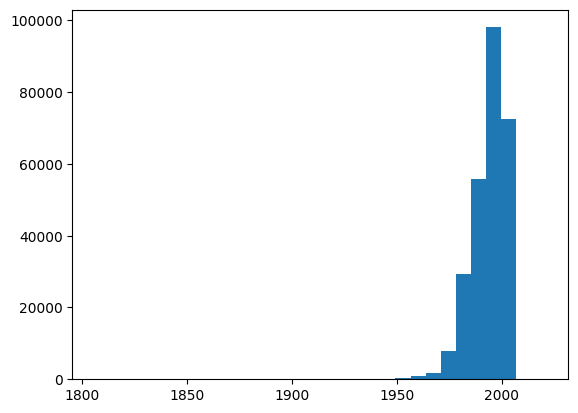

In [287]:
def convert_value(x):
  if isinstance(x, str):
    if x.isdigit():
      x = int(x)
    else:
      return np.nan
  if x < 1800 or x > 2023:
    return np.nan
  return x


years = books.astype({'Year-Of-Publication': 'int64'})
years = years['Year-Of-Publication'].apply(convert_value)
plt.hist(years, 30)

3. Покажем на [столбчатой диаграмме](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html) топ-5 стран, в которых живут пользователи из датасета. Для этого понадобится сгруппировать столбец со страной методом [groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html). Не забудьте отсортировать столбцы ([sort_values()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)).

Количетсво юзеров по отзывам

<Axes: ylabel='Third-Location'>

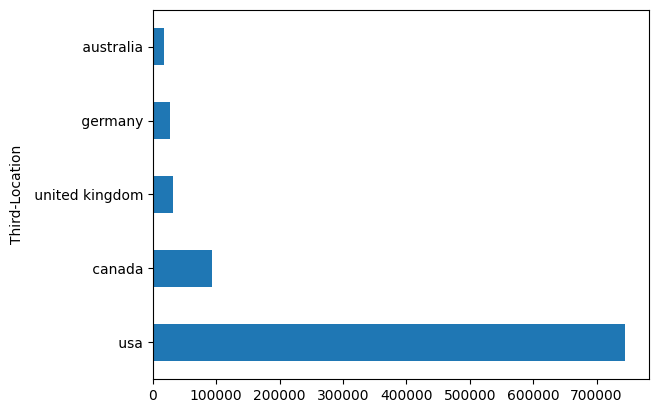

In [288]:
mask = data['Third-Location'] != '' # откидываем некорректные значения
data = data[mask]

countries = data.groupby(['Third-Location'])['Third-Location'].count().sort_values(ascending=False).head(5)
countries.plot.barh()

По количеству юзеров

<Axes: ylabel='Third-Location'>

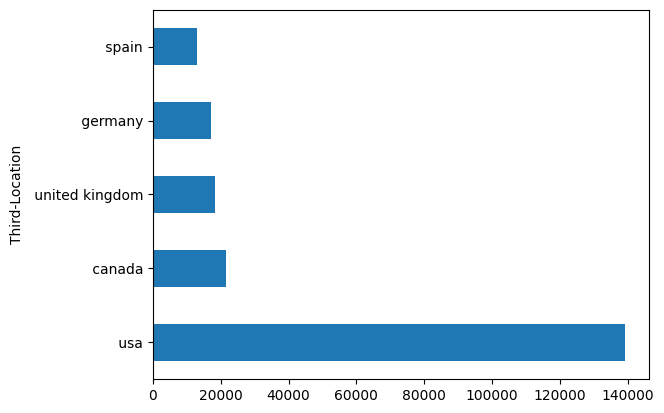

In [289]:
location = users["Location"].str.split(',', expand=True, n=3)
location.rename(columns={0: 'First-Location', 1: 'Second-Location', 2: 'Third-Location'}, inplace=True)
users.drop(columns=['Location'], inplace=True)
users = users.merge(location, left_index=True, right_index=True)

mask = users['Third-Location'] != '' # откидываем некорректные значения
users = users[mask]

countries = users.groupby(['Third-Location'])['Third-Location'].count().sort_values(ascending=False).head(5)
countries.plot.barh()

### Упражнения

Теперь выполним несколько упражнений с данными.

1. Найдите книги, которые оценивали и жители России, и жители США. Посчитайте, жители какой страны в среднем ставили более высокие оценки одним и тем же книгам. Ретинг 0 не учитывайте.

In [42]:
russian_ratings_mask = data['Third-Location'].str.contains('russia')
russian_ratings = data[russian_ratings_mask]
russian_ratings_books = russian_ratings['ISBN']
russian_ratings_names = russian_ratings['Book-Title']

usa_ratings_mask = data['Third-Location'].str.contains('usa')
usa_ratings = data[usa_ratings_mask]
usa_ratings_books = usa_ratings['ISBN']
usa_ratings_names = usa_ratings['Book-Title']



togetherly_ratings_isbns = np.intersect1d(russian_ratings_books, usa_ratings_books)
togetherly_ratings_names = np.intersect1d(russian_ratings_names, usa_ratings_names)
print(togetherly_ratings_names)


mask = russian_ratings['ISBN'].isin(togetherly_ratings_isbns)
russian_ratings = russian_ratings[mask]

mask = usa_ratings['ISBN'].isin(togetherly_ratings_isbns)
usa_ratings = usa_ratings[mask]






['A Lesson Before Dying (Vintage Contemporaries (Paperback))'
 'A Patchwork Planet' 'Angel Light: An Old-Fashioned Love Story'
 'Arch of Triumph'
 "Band of Brothers : E Company, 506th Regiment, 101st Airborne from Normandy to Hitler's Eagle's Nest"
 'Bright lights, big city: A novel'
 'Dear America: Letters Home from Vietnam' 'Dragonfly in Amber'
 'Family Ties: Alex Gets the Business' 'Fine Things'
 'First Love, Last Rites' 'Five Days in London, May 1940' 'Forrest Gump'
 'Johnny Tremain (Laurel Leaf Books)'
 'Loving Your Long-Distance Relationship' 'Medicine Woman' 'Momo'
 'Outlander' 'Pandora (New Tales of the Vampires)'
 "Philip &amp; Alex's Guide to Web Publishing"
 'Reengineering the Corporation: A Manifesto for Business Revolution'
 'Round Ireland With a Fridge' 'Saucer' 'Seventh Heaven'
 'Snow Falling on Cedars' "Son of Avonar (The Bridge of D'Arnath, Book 1)"
 "Stephen Coonts' Deep Black (Deep Black)" 'The Accidental Pope: A Novel'
 'The Age of Innocence (Signet Classics (Paperb

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,First-Location,Second-Location,Third-Location,3
18430,0553277472,Zen and the Art of Motorcycle Maintenance: An ...,ROBERT PIRSIG,1984,Bantam,http://images.amazon.com/images/P/0553277472.0...,http://images.amazon.com/images/P/0553277472.0...,http://images.amazon.com/images/P/0553277472.0...,46398,10,37.0,san antonio,texas,usa,None
18966,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,49300,7,NaN,loveland,colorado,usa,None
19076,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,113270,8,25.0,evanston,illinois,usa,None
19119,067976402X,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...,113270,10,25.0,evanston,illinois,usa,None
19558,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,113519,9,NaN,pleasanton,california,usa,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005242,0061092886,The Fallen Man (Joe Leaphorn Novels),Tony Hillerman,1997,HarperTorch,http://images.amazon.com/images/P/0061092886.0...,http://images.amazon.com/images/P/0061092886.0...,http://images.amazon.com/images/P/0061092886.0...,139635,8,NaN,maplewood,minnesota,usa,None
1005245,0061092886,The Fallen Man (Joe Leaphorn Novels),Tony Hillerman,1997,HarperTorch,http://images.amazon.com/images/P/0061092886.0...,http://images.amazon.com/images/P/0061092886.0...,http://images.amazon.com/images/P/0061092886.0...,232438,8,NaN,woodbury,minnesota,usa,None
1005246,0061092886,The Fallen Man (Joe Leaphorn Novels),Tony Hillerman,1997,HarperTorch,http://images.amazon.com/images/P/0061092886.0...,http://images.amazon.com/images/P/0061092886.0...,http://images.amazon.com/images/P/0061092886.0...,245527,8,NaN,butte,montana,usa,None
1005247,0061092886,The Fallen Man (Joe Leaphorn Novels),Tony Hillerman,1997,HarperTorch,http://images.amazon.com/images/P/0061092886.0...,http://images.amazon.com/images/P/0061092886.0...,http://images.amazon.com/images/P/0061092886.0...,269107,10,38.0,loveland,colorado,usa,None


In [47]:
mask = russian_ratings['Book-Rating']!=0
russian_ratings = russian_ratings[mask]
print("Russia: " + str(russian_ratings['Book-Rating'].mean()))

mask = usa_ratings['Book-Rating']!=0
usa_ratings = usa_ratings[mask]
print("Usa: "+ str(usa_ratings['Book-Rating'].mean()))

print("Russia win")

Russia: 8.142857142857142
Usa: 7.959325396825397
Russia win


2. Найдите год, в который было выпущено наибольшее количество книг. И год, в который наименьшее. Выведите годы и количество выпущенных книг.

In [64]:
def convert_value(x):
  if isinstance(x, str):
    if x.isdigit():
      x = int(x)
    else:
      return np.nan
  if x > 2023:
    return np.nan
  return int(x)

years = books['Year-Of-Publication'].apply(convert_value)
years_df = years. to_frame (name='Years')
#years_df
years_df = years_df.groupby(['Years'])['Years'].count().sort_values(ascending=False)
years_max = years_df.head(1)
print("Max year:")
display(years_max)
years_min = years_df.sort_values(ascending=True).head(1)
print("Min year:")
display(years_min)

Max year:


Years
2002.0    17627
Name: Years, dtype: int64

Min year:


Years
2021.0    1
Name: Years, dtype: int64

## Упражнения с данными в pyspark

Повторим все те же действия, но с помощью PySpark.

### Подготовка

Загрузим данные и посмотрим на них. Метод show() зпускает выполнение операций, прописанных для датафрейма.

In [367]:
books = spark.read.option("header", True).csv("Books.csv")
ratings = spark.read.option("header", True).csv("Ratings.csv")
users = spark.read.option("header", True).csv("Users.csv")
books.show()
ratings.show()
users.show()

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari

Посмотрим на размеры датафреймов.

In [368]:
(books.count(), len(books.columns)), (ratings.count(), len(ratings.columns)), (users.count(), len(users.columns))

((271360, 8), (1149780, 3), (278859, 3))

In [373]:
books=books.withColumnRenamed('ISBN', 'bookISBN')
books.show()

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|  bookISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari

Воспользуйтесь [функцией](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.join.html) join, чтобы объединить три датафрейма в один.

In [374]:
data = books.join(ratings, books.bookISBN == ratings.ISBN)
data = data.join(users, data['User-ID'] == users['User-ID'])
data.show()

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------+----------+-----------+-------+--------------------+----+
|  bookISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|User-ID|      ISBN|Book-Rating|User-ID|            Location| Age|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------+----------+-----------+-------+--------------------+----+
|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|   1000|8850200005|          0|   1000|teramo, abruzzo, ...|34.0|
|0345339703|The Fellowship of...|      J.R.R. TOLKIEN|               1986|             Del Rey|http://im

In [375]:
(data.count(), len(data.columns))

(1031136, 14)

В столбце Location указано достаточно много данных: город, регион, страна. Давайте разделим этот столбец на три с помощью функции [split()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.split.html) и функции [withColumn()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.withColumn.html). Если в процессе у вас образовались лишние столбцы, удалите их методом [drop()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.drop.html). Это случилось потому, что со столбцом с локацией есть некоторые проблемы, но мы на них сейчас не будем обращать внимание.

In [376]:
import pyspark.sql.functions as f

In [377]:
split_col = f.split(data['Location'], ',')
data = data.withColumn('First-Location', split_col.getItem(0))
data = data.withColumn('Second-Location', split_col.getItem(1))
data = data.withColumn('Third-Location', split_col.getItem(2))
data = data.drop('Location')
data.show()

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------+----------+-----------+-------+----+--------------+-----------------+--------------+
|  bookISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|User-ID|      ISBN|Book-Rating|User-ID| Age|First-Location|  Second-Location|Third-Location|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------+----------+-----------+-------+----+--------------+-----------------+--------------+
|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|   1000|8850200005|          0|   1000|34.0|        teramo|          abruzzo|         ita

Узнаем немного больше о книгах и пользователях.
1. Построим [гистограмму](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) распределения возрастов пользователей. Видно, что там есть отсутствующие значения. Будем их пока игнорировать.

In [378]:
ages = data.select(f.collect_list('Age')).first()[0]




In [379]:
for i in range(len(ages)):
  try:
    ages[i] = float(ages[i])
  except Exception as e:
    ages[i] = np.nan

# вынуждены сделать проверку, так как есть значения со странами, а не с возрастами

(array([6.13000e+03, 9.61960e+04, 3.06828e+05, 1.99123e+05, 1.11135e+05,
        2.87050e+04, 1.82800e+03, 2.72000e+02, 9.25000e+02, 9.77000e+02,
        1.90000e+01, 1.37000e+02, 1.38000e+02, 4.00000e+01, 0.00000e+00,
        0.00000e+00, 5.43000e+02, 3.20000e+01, 9.50000e+01, 1.26000e+02]),
 array([  0. ,  12.2,  24.4,  36.6,  48.8,  61. ,  73.2,  85.4,  97.6,
        109.8, 122. , 134.2, 146.4, 158.6, 170.8, 183. , 195.2, 207.4,
        219.6, 231.8, 244. ]),
 <BarContainer object of 20 artists>)

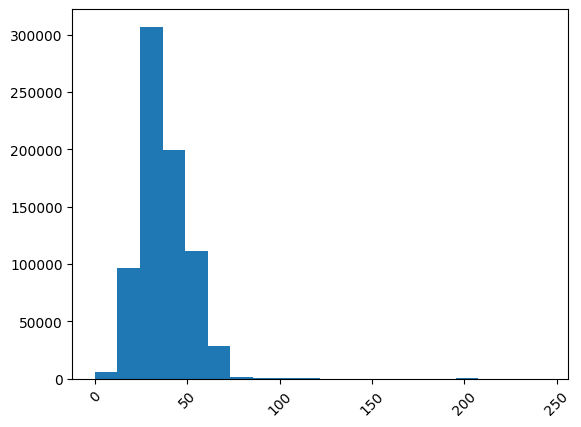

In [380]:
plt.xticks(rotation=45)
plt.hist(ages,20)

In [381]:
data.describe(["Age"]).show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            753333|
|   mean| 37.39758831409003|
| stddev|14.098294242258431|
|    min|      \""n/a\"""""|
|    max|              99.0|
+-------+------------------+



Для того, чтобы отсеять лишние строки, можно воспользоваться методом [filter()/where()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.filter.html).

Для сортировки можно воспользоваться методом [sort()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sort.html).

In [382]:
#put_your_code_here
data = data.where("Age <=100 and Age >=20")

In [383]:
data.describe(["Age"]).show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            714023|
|   mean|38.100866498698224|
| stddev|11.430538733388968|
|    min|             100.0|
|    max|              99.0|
+-------+------------------+



In [384]:
ages = data.select(f.collect_list('Age')).first()[0]


In [385]:
ages = list(map(float, ages))

(array([4.74400e+04, 8.47200e+04, 1.09771e+05, 1.04812e+05, 8.66060e+04,
        6.27880e+04, 6.81590e+04, 4.54920e+04, 4.06470e+04, 2.90150e+04,
        1.92840e+04, 9.06900e+03, 3.26600e+03, 1.17400e+03, 6.67000e+02,
        6.67000e+02, 5.40000e+01, 4.70000e+01, 8.30000e+01, 2.62000e+02]),
 array([ 20.,  24.,  28.,  32.,  36.,  40.,  44.,  48.,  52.,  56.,  60.,
         64.,  68.,  72.,  76.,  80.,  84.,  88.,  92.,  96., 100.]),
 <BarContainer object of 20 artists>)

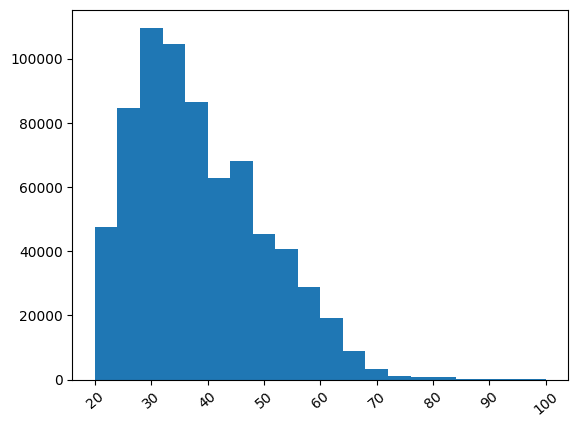

In [386]:
plt.xticks(rotation=40)
plt.hist(ages,20)

Какой можно сделать вывод о возрасте пользователей?

# Основная масса - люди от 25 до 40 лет

2. Выясним, книги каких эпох представлены в датасете. Для этого построим еще диаграмму, теперь - с распределением кол-ва книг по годам.

In [387]:
books_1 = books.where(books['Year-Of-Publication'] <=2023)
books_1 = books_1.where(books['Year-Of-Publication'] >=1807)

In [388]:
years = books_1.select(f.collect_list('Year-Of-Publication')).first()[0]


In [389]:
years = list(map(float, years))

(array([1.30000e+01, 5.00000e+00, 2.10000e+01, 3.70000e+01, 2.10000e+01,
        3.50000e+01, 6.70000e+01, 5.70000e+01, 1.40000e+02, 4.14000e+02,
        9.46000e+02, 1.93000e+03, 7.42700e+03, 1.89840e+04, 3.81180e+04,
        7.79180e+04, 1.00283e+05, 2.02440e+04, 5.00000e+00, 4.00000e+00]),
 array([1897. , 1903.2, 1909.4, 1915.6, 1921.8, 1928. , 1934.2, 1940.4,
        1946.6, 1952.8, 1959. , 1965.2, 1971.4, 1977.6, 1983.8, 1990. ,
        1996.2, 2002.4, 2008.6, 2014.8, 2021. ]),
 <BarContainer object of 20 artists>)

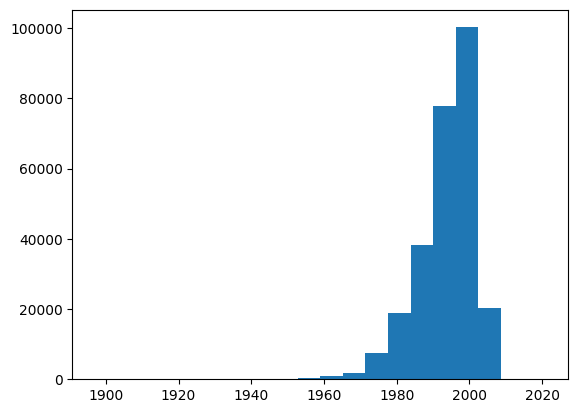

In [390]:
plt.hist(years,20)

Вероятно, у вас возникла ошибка о невозможности сравнения строк и целых чисел. Посмотрим на уникальные значения с помощью метода [distinct()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.distinct.html).

In [391]:
years = books.select("Year-Of-Publication")
years.distinct().show()

+--------------------+
| Year-Of-Publication|
+--------------------+
| and Murder (St. ...|
|                1953|
|                1957|
|                1987|
|                1956|
|                1936|
|                2020|
|                1958|
|                1910|
|                1943|
|                1972|
|                1931|
|                2026|
| and Musicians at...|
| and Box-Office M...|
|                1988|
|                1926|
|                1938|
|                1911|
|\"" \""Drachenste...|
+--------------------+
only showing top 20 rows



В 4 строках некорректно открепили автора от названия. Для упрощения работы исключим эти строки из датасета.

In [392]:
#put your code here
years = years.filter(years['Year-Of-Publication']>1807)
years = years.filter(years['Year-Of-Publication']<2023)
years.select("Year-Of-Publication").distinct().show()


+-------------------+
|Year-Of-Publication|
+-------------------+
|               1953|
|               1957|
|               1987|
|               1956|
|               1936|
|               2020|
|               1958|
|               1910|
|               1943|
|               1972|
|               1931|
|               1988|
|               1926|
|               1938|
|               1911|
|               1932|
|               1977|
|               1971|
|               1984|
|               1982|
+-------------------+
only showing top 20 rows



Теперь продолжим с построением графика. Но сначала преобразуем весь столбец в целые числа с помощью метода [cast()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.cast.html).

In [393]:
#put your code here
years = years.select(years['Year-Of-Publication'].cast("int").alias('Year-Of-Publication'))


In [394]:
years.show()

+-------------------+
|Year-Of-Publication|
+-------------------+
|               2002|
|               2001|
|               1991|
|               1999|
|               1999|
|               1991|
|               2000|
|               1993|
|               1996|
|               2002|
|               1988|
|               2000|
|               2004|
|               1999|
|               1998|
|               1998|
|               1999|
|               1994|
|               1999|
|               1994|
+-------------------+
only showing top 20 rows



In [395]:
years = years.select(f.collect_list('Year-Of-Publication')).first()[0]



(array([1.30000e+01, 5.00000e+00, 2.10000e+01, 3.70000e+01, 2.10000e+01,
        3.50000e+01, 6.70000e+01, 5.70000e+01, 1.40000e+02, 4.14000e+02,
        9.46000e+02, 1.93000e+03, 7.42700e+03, 1.89840e+04, 3.81180e+04,
        7.79180e+04, 1.00283e+05, 2.02440e+04, 5.00000e+00, 4.00000e+00]),
 array([1897. , 1903.2, 1909.4, 1915.6, 1921.8, 1928. , 1934.2, 1940.4,
        1946.6, 1952.8, 1959. , 1965.2, 1971.4, 1977.6, 1983.8, 1990. ,
        1996.2, 2002.4, 2008.6, 2014.8, 2021. ]),
 <BarContainer object of 20 artists>)

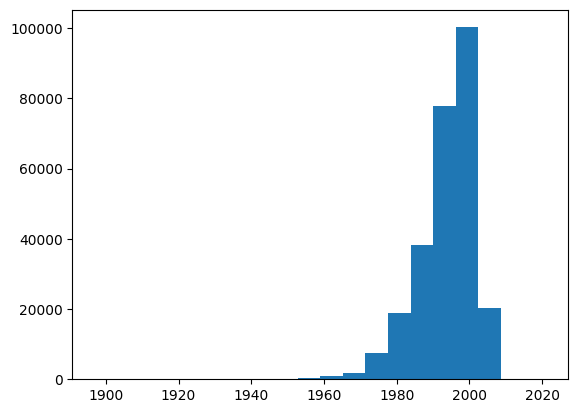

In [396]:
plt.hist(years,20)

3. Покажем на столбчатой диаграмме топ-5 стран, в которых живут пользователи из датасета. Для этого понадобится сгруппировать столбец со страной методом [groupBy()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html). Не забудьте отсортировать столбцы.

<Axes: ylabel='Third-Location'>

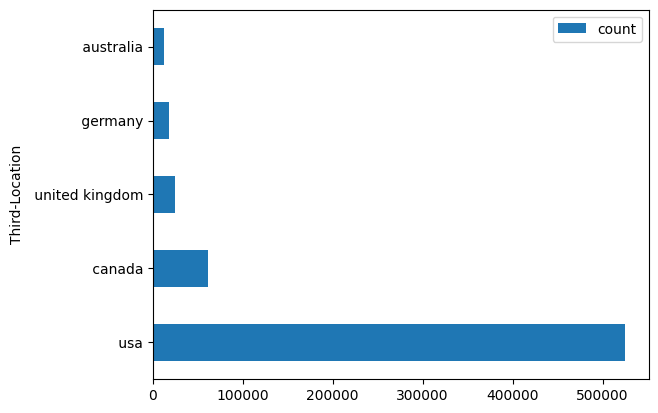

In [397]:
countries = data.groupBy("Third-Location").count().sort("count", ascending=False)
countries = countries.limit(5).toPandas().set_index("Third-Location")
countries.plot.barh()

### Упражнения

Теперь выполним несколько упражнений с данными.

1. Найдите книги, которые оценивали и жители России, и жители США. Посчитайте, жители какой страны в среднем ставили более высокие оценки одним и тем же книгам. Ретинг 0 не учитывайте.

In [399]:
#put your code here
rus = data.where(data['Third-Location'] ==' russia')
#rus.show()
rus = rus.select(f.collect_list("bookISBN")).first()[0]
#rus

us = data.where(data['Third-Location'] ==' usa')
#rus.show()
us = us.select(f.collect_list("bookISBN")).first()[0]
us

['0515131520',
 '0441005470',
 '0425087859',
 '0553574566',
 '0767905385',
 '0553580906',
 '014037423X',
 '0425144917',
 '0451150244',
 '0842329129',
 '0446606723',
 '0553351702',
 '0886773776',
 '052547014X',
 '0671440683',
 '0684719045',
 '0345367421',
 '0515137111',
 '0786861754',
 '067174139X',
 '0446530115',
 '0446605581',
 '0553280465',
 '0609800256',
 '0671002481',
 '0767905385',
 '0842329129',
 '0425188787',
 '0060801115',
 '0842329129',
 '0140440488',
 '0767905385',
 '0425105156',
 '0515137111',
 '0553276387',
 '0842329129',
 '0380818817',
 '0345419073',
 '088138044X',
 '0446605581',
 '0446605581',
 '0375508112',
 '0553574566',
 '0767905385',
 '0061031992',
 '0670865796',
 '0374121230',
 '0881661775',
 '0425188787',
 '0618159789',
 '0821744526',
 '0446609005',
 '0380792206',
 '0449146448',
 '0688141862',
 '0553580906',
 '0553581554',
 '0345379586',
 '0553580906',
 '0373482078',
 '0671002481',
 '0515137111',
 '0380385880',
 '0425195244',
 '0553580906',
 '0451197690',
 '08910986

In [400]:

together = list(set(rus).intersection(set(us)))
together

['0440215625',
 '0300080301',
 '074322454X',
 '0375702709',
 '0679428313',
 '0812544412',
 '0394756886',
 '0440200563',
 '0679760806',
 '0446672211',
 '0440212561',
 '0393323048',
 '0312983212',
 '0743453255',
 '0451526120',
 '080411918X',
 '0140386335',
 '0345417623',
 '0553269631',
 '1931313644',
 '0140079165',
 '0061092886',
 '0062500260',
 '0553277472',
 '0449220184',
 '0312242360',
 '0312985207',
 '0425184463',
 '0099271087',
 '067088040X',
 '0380752352',
 '067976402X']

In [409]:
rus = data.where(data['Third-Location'] ==' russia')
us = data.where(data['Third-Location'] ==' usa')

rus_together_books = rus.filter(f.col("bookISBN").isin(together))
us_together_books =us.filter(f.col("bookISBN").isin(together))
rus_together_books.show()

+----------+--------------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------+----------+-----------+-------+----+--------------+------------------+--------------+
|  bookISBN|          Book-Title|     Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|User-ID|      ISBN|Book-Rating|User-ID| Age|First-Location|   Second-Location|Third-Location|
+----------+--------------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------+----------+-----------+-------+----+--------------+------------------+--------------+
|0553277472|Zen and the Art o...|   ROBERT PIRSIG|               1984|              Bantam|http://images.ama...|http://images.ama...|http://images.ama...| 260383|0553277472|          0| 260383|23.0| st.petersburg| north-west russia|        russia|
|0679760

In [410]:

rus_together_books = rus.filter(rus_together_books["Book-Rating"]!=0)

us_together_books = us.filter(us_together_books["Book-Rating"]!=0)
rus_together_books.show()

+----------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+--------------------+-------+----------+-----------+-------+----+--------------+---------------+--------------+
|  bookISBN|          Book-Title|         Book-Author|Year-Of-Publication|         Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|User-ID|      ISBN|Book-Rating|User-ID| Age|First-Location|Second-Location|Third-Location|
+----------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+--------------------+-------+----------+-----------+-------+----+--------------+---------------+--------------+
|0679419306|Rasputin: The Sai...|      Brian Moynahan|               1997|  Random House Inc|http://images.ama...|http://images.ama...|http://images.ama...| 232001|0679419306|         10| 232001|31.0|  petrozavodsk|        karelia|        russia|
|0679760806|

In [411]:
print("Russia: ")
rus_together_books = rus_together_books.agg(f.avg("Book-Rating"))
rus_together_books.show()



Russia: 
+-----------------+
| avg(Book-Rating)|
+-----------------+
|9.428571428571429|
+-----------------+



In [412]:
print("Usa: ")
us_together_books = us_together_books.agg(f.avg("Book-Rating"))
us_together_books.show()

Usa: 
+-----------------+
| avg(Book-Rating)|
+-----------------+
|7.815447248368655|
+-----------------+



In [ ]:
print("Russia win again")

2. Найдите год, в который было выпущено наибольшее количество книг. И год, в который наименьшее. Выведите годы и количество выпущенных книг.

In [415]:
#put your code here
years = books.filter(f.col("Year-Of-Publication") > 0).groupBy("Year-Of-Publication").agg(f.count("bookISBN").alias("Count")).sort("Year-Of-Publication")
max = years.filter(f.col("Count") == years.agg(f.max("Count")).collect()[0][0])
min = years.filter(f.col("Count") == years.agg(f.min("Count")).collect()[0][0])
min.show()
max.show()

+-------------------+-----+
|Year-Of-Publication|Count|
+-------------------+-----+
|               1961|    1|
|               1376|    1|
|               1378|    1|
|               1806|    1|
|               1897|    1|
|               1904|    1|
|               1906|    1|
|               1908|    1|
|               1910|    1|
|               1914|    1|
|               1917|    1|
|               1919|    1|
|               1934|    1|
|               2008|    1|
|               2012|    1|
|               2021|    1|
|               2024|    1|
|               2026|    1|
|               2037|    1|
|               2038|    1|
+-------------------+-----+

+-------------------+-----+
|Year-Of-Publication|Count|
+-------------------+-----+
|               2002|17624|
+-------------------+-----+

